In [1]:
from PIL import Image
import json
import matplotlib.pyplot as plt

from utils import *
from vis_prior_layout import UniformRandomNoClipVPL
from vis_prior_generator import CannyVPG, HEDVPG, MLSDVPG, MidasVPG, UniformerVPG

import sys
sys.path.append("/home/ubuntu/dad/ControlNet")
from share import *
import config
import cv2
import einops
# import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.hed import HEDdetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

logging improved.


In [2]:
apply_hed = HEDdetector()

model = create_model('/home/ubuntu/dad/ControlNet/models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('/home/ubuntu/dad/ControlNet/models/control_sd15_hed.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)


def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map = apply_hed(resize_image(input_image, detect_resolution))
        detected_map = HWC3(detected_map)
        img = resize_image(input_image, image_resolution)
        H, W, C = img.shape

        detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [detected_map] + results


No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [/home/ubuntu/dad/ControlNet/models/cldm_v15.yaml]
Loaded state_dict from [/home/ubuntu/dad/ControlNet/models/control_sd15_hed.pth]


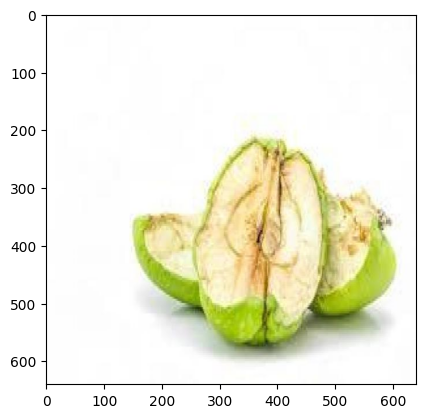

In [3]:
labels_path="/home/ubuntu/dad/roboflow-100-benchmark/rf100/apples-fvpl5/valid/_annotations.coco.json"
with open(labels_path, "r") as f:
    anno = json.load(f)
ann_id = 666
im_path = "/home/ubuntu/dad/roboflow-100-benchmark/rf100/apples-fvpl5/valid/"+anno["images"][anno["annotations"][ann_id]['image_id']]['file_name']
img = imread(im_path)
bbox = anno["annotations"][ann_id]['bbox']

plt.imshow(img[:,:,::-1])

In [4]:
result = process(input_image=img, 
                prompt="a picture of damaged apples", 
                a_prompt="realistic", 
                n_prompt="painting", 
                num_samples=1, 
                image_resolution=512, 
                detect_resolution=512, 
                ddim_steps=50, 
                guess_mode=False, 
                strength=1., 
                scale=9., 
                seed=1, 
                eta=0.,
                )

Global seed set to 1


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.43it/s]


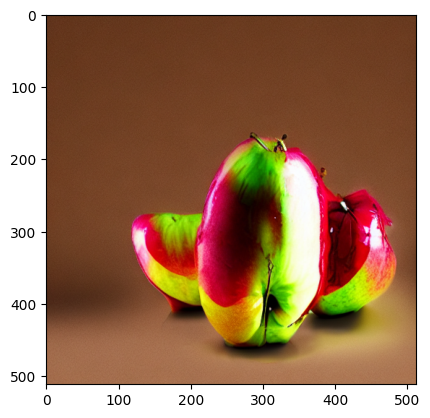

In [5]:
plt.imshow(result[1])

In [6]:
from PIL import Image
import json
import matplotlib.pyplot as plt

from utils import *
from vis_prior_layout import UniformRandomNoClipVPL
from vis_prior_generator import CannyVPG, HEDVPG, MLSDVPG, MidasVPG, UniformerVPG

In [7]:
labels_path="/home/ubuntu/dad/roboflow-100-benchmark/rf100/apples-fvpl5/valid/_annotations.coco.json"
im_folder = "/home/ubuntu/dad/roboflow-100-benchmark/rf100/apples-fvpl5/valid/"
naive_vpd = UniformRandomNoClipVPL()
hedVPG = HEDVPG(vpl=naive_vpd, fill_val=0, annotation=labels_path, im_folder=im_folder)

failed to detect annotation: 248
failed to detect annotation: 491
prior bank updated


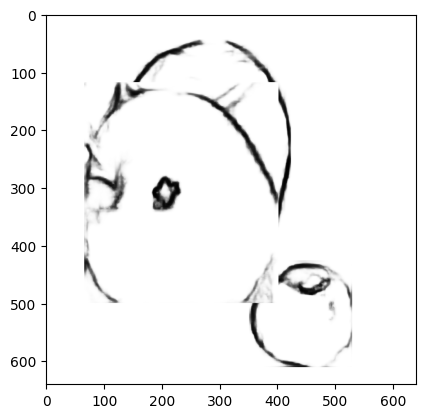

In [59]:
hed_prior = hedVPG.visualize_one_layout(im_shape=img.shape, category_name=None, prior_mode=None, fill_val=None)
plt.imshow(hed_prior, cmap='Greys')

In [ ]:
result = process(input_image=hed_prior.astype(np.uint8), 
                prompt="a picture of apples", 
                a_prompt="", 
                n_prompt="", 
                num_samples=1, 
                image_resolution=512, 
                detect_resolution=512, 
                ddim_steps=50, 
                guess_mode=False, 
                strength=1., 
                scale=9., 
                seed=9, 
                eta=0.,
                )
plt.imshow(result[1])

Global seed set to 9


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:  30%|███████████████████████████████▊                                                                          | 15/50 [00:04<00:10,  3.45it/s]